# CVC Data Summaries

## Setup the basic working environment

In [1]:
%matplotlib inline

import os
import sys
import datetime
import imp

import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn
seaborn.set(style='ticks', context='paper')

import wqio
import pybmp
import pynsqd

import pycvc

min_precip = 1.9999
palette = seaborn.color_palette('deep', n_colors=6)
pybmp.setMPLStyle()
POCs = [p['cvcname'] for p in filter(lambda p: p['include'], pycvc.info.POC_dicts)]

# imp.reload(cvc)
# imp.reload(cvc.dataAccess)
# imp.reload(cvc.external)
# imp.reload(cvc.summary)
# imp.reload(cvc.viz)
# imp.reload(cvc.info)
# imp.reload(cvc)


## Hydrologic Relationships

$V_{\mathrm{runoff, \ LV1}} = \max\left(0,\: -12.05 + 2.873\, D_{\mathrm{precip}} + 0.863 \, \Delta t \right)$

In [2]:
def LV1_runoff(row):
    return max(0, -12.0 + 2.87 * row['total_precip_depth'] + 0.863 * row['duration_hours'])

### ED-1
$\log \left(V_{\mathrm{runoff, \ ED1}}\right) = 1.58 + 0.01 \, I_{\mathrm{max}} + 0.0163 \, D_{\mathrm{precip}} $

$V_{\mathrm{bypass, \ ED1}} = \max \left(0,\: -53.08 + 8.30 \, I_{\mathrm{max}} + 1.22 \, D_{\mathrm{precip}} \right)$

$V_{\mathrm{inflow, \ ED1}} = \max \left(0,\: V_{\mathrm{runoff, \ ED1}} - V_{\mathrm{bypass, \ ED1}} \right)$

In [3]:
def ED1_runoff(row):
    return 10**(1.58 + 0.000667 * row['peak_precip_intensity'] + 0.0169 * row['total_precip_depth'] )

def ED1_bypass(row):
    return max(0, -26.4 + 0.184 * row['peak_precip_intensity'] + 1.22 * row['total_precip_depth'])

def ED1_inflow(row):
    return max(0, ED1_runoff(row) - ED1_bypass(row))

### LV-2
$\log \left(V_{\mathrm{runoff, \ LV2}}\right) = 1.217 + 0.036 \, I_{\mathrm{max}} + 0.0247 \, D_{\mathrm{precip}} $

$V_{\mathrm{bypass, \ LV2}} = 0$

$V_{\mathrm{inflow, \ LV2}} = \max \left(0,\: V_{\mathrm{runoff, \ LV2}} - V_{\mathrm{bypass, \ LV2}} \right)$

In [4]:
def LV2_runoff(row):
    return 10**(1.22 + 0.00622 * row['peak_precip_intensity'] + 0.0244 * row['total_precip_depth'] )

def LV2_bypass(row):
    return 0 #max(0, 1.49 * row['total_precip_depth'] + 7.72 * row['peak_precip_intensity'] - 56.47)

def LV2_inflow(row):
    return max(0, LV2_runoff(row) - LV2_bypass(row))

### LV-4
$\log \left(V_{\mathrm{runoff, \ LV4}}\right) = 1.35  + 0.039 \, I_{\mathrm{max}} + 0.0094 \, D_{\mathrm{precip}} $

$V_{\mathrm{bypass, \ LV4}} = \max \left(0,\: 7.37 + 0.223 \, I_{\mathrm{max}} + 0.112 \, D_{\mathrm{precip}} \right)$

$V_{\mathrm{inflow, \ LV4}} = \max \left(0,\: V_{\mathrm{runoff, \ LV4}} - V_{\mathrm{bypass, \ LV4}} \right)$

In [5]:
def LV4_runoff(row):
    return 10**(1.35 + 0.00650 * row['peak_precip_intensity'] + 0.00940 * row['total_precip_depth'] )

def LV4_bypass(row):
    return max(0, 7.36 + 0.0370 * row['peak_precip_intensity'] + 0.112 * row['total_precip_depth'])

def LV4_inflow(row):
    return max(0, LV4_runoff(row) - LV4_bypass(row))

## Water quality loading relationship

$ M_{\mathrm{runoff}} = V_{\mathrm{runoff}} \times \hat{\mathbb{C}}_{\mathrm{inflow}}\left(\mathrm{landuse,\ season}\right) $

$ M_{\mathrm{bypass}} = V_{\mathrm{bypass}} \times \hat{\mathbb{C}}_{\mathrm{inflow}}\left(\mathrm{landuse,\ season}\right) $

$ M_{\mathrm{inflow}} = M_{\mathrm{runoff}} - M_{\mathrm{bypass}} $

$ M_{\mathrm{outflow}} = V_{\mathrm{outflow}} \times \mathbb{C}_{\mathrm{outflow}} $

## Load External Data (this takes a while)

In [6]:
bmpdb = pycvc.external.bmpdb(palette[3], 'D')
nsqdata = pycvc.external.nsqd(palette[2], 'd')

OSError: File b'C:\\Users\\phobson\\AppData\\Local\\Continuum\\Miniconda3\\envs\\cvctest\\pybmp_data\\data\\bmpdata.csv' does not exist

## Load CVC Database

In [7]:
cvcdbfile = "data/cvc.accdb"
cvcdb = pycvc.Database(cvcdbfile, nsqdata, bmpdb, testing=False)

### Define the site object for the reference site and compute its median values ("influent" to other sites)

In [8]:
LV1 = pycvc.Site(cvcdb, 'LV-1', 'LV-1', tocentry='Lakeview Control', isreference=True, 
               runoff_fxn=LV1_runoff, minprecip=min_precip, color=palette[1], marker='s')

### Lakeview "influent" data from LV-1

In [9]:
LV_Influent = (
    LV1.wqdata
       .query("sampletype == 'composite'")
       .groupby(by=['season', 'parameter', 'units'])['concentration']
       .median()
       .reset_index()
       .rename(columns={'concentration': 'influent median'}) 
)
LV_Influent.head()

,season,parameter,units,influent median
0,autumn,Aluminum (Al),ug/L,113.00
1,autumn,Cadmium (Cd),ug/L,0.09
2,autumn,Copper (Cu),ug/L,7.75
3,autumn,Dissolved Chloride (Cl),mg/L,4.00
4,autumn,Escherichia coli,CFU/100mL,28.50


### Elm Drive 'influent' data from NSQD

In [10]:
ED_Influent = (
    cvcdb.nsqdata
         .medians.copy()
         .rename(columns={'NSQD Medians': 'influent median'})
)
ED_Influent.head()

,season,parameter,units,influent median
0,autumn,Cadmium (Cd),ug/L,0.70
1,autumn,Copper (Cu),ug/L,18.00
2,autumn,Dissolved Chloride (Cl),mg/L,2.30
3,autumn,Escherichia coli,MPN/100 mL,15500.00
4,autumn,Lead (Pb),ug/L,16.25


### Remaining site objects

In [11]:
ED1 = pycvc.Site(cvcdb, 'ED-1', 'ED-1', tocentry='Elm Drive',
               influentmedians=ED_Influent, 
               minprecip=min_precip, isreference=False,
               runoff_fxn=ED1_runoff, bypass_fxn=ED1_bypass,
               inflow_fxn=ED1_inflow, color=palette[0], marker='o')

LV2 = pycvc.Site(cvcdb, 'LV-2', 'LV-1', tocentry='Lakeview Grass Swale',
               influentmedians=LV_Influent, 
               minprecip=min_precip, isreference=False,
               runoff_fxn=LV2_runoff, bypass_fxn=LV4_bypass,
               inflow_fxn=LV4_inflow, color=palette[4], marker='^')

LV4 = pycvc.Site(cvcdb, 'LV-4', 'LV-1', tocentry=r'Lakeview Bioswale 1$^{\mathrm{st}}$ South Side',
               influentmedians=LV_Influent, 
               minprecip=min_precip, isreference=False,
               runoff_fxn=LV4_runoff, bypass_fxn=LV4_bypass,
               inflow_fxn=LV4_inflow, color=palette[5], marker='v')

### Fix ED-1 storm that had two composite samples

In [12]:
ED1.hydrodata.data.loc['2012-08-10 23:50:00':'2012-08-11 05:20', 'storm'] = 0
ED1.hydrodata.data.loc['2012-08-11 05:30':, 'storm'] += 1

### Replace total inflow volume with estimate from simple method for 2013-07-08 storm

In [13]:
storm_date = datetime.date(2013, 7, 8)
for site in [ED1, LV1, LV2, LV4]:
    bigstorm = site.storm_info.loc[site.storm_info.start_date.dt.date == storm_date].index[0]
    inflow = site.drainagearea.simple_method(site.storm_info.loc[bigstorm, 'total_precip_depth'])
    site.storm_info.loc[bigstorm, 'inflow_m3'] = inflow
    

## High-level summaries

### Hydrologic Summary

In [14]:
stormfile = pandas.ExcelWriter("output/xlsx/CVCHydro_StormInfo.xlsx")
hydrofile = pandas.ExcelWriter("output/xlsx/CVCHydro_StormStats.xlsx")
for site in [ED1, LV1, LV2, LV4]:
    site.storm_info.to_excel(stormfile, sheet_name=site.siteid)
    site.storm_stats.to_excel(hydrofile, sheet_name=site.siteid)
    
stormfile.save()
stormfile.close()
hydrofile.save()
hydrofile.close()

### Hydrologic Pairplots 

failed on LV-2, outflow


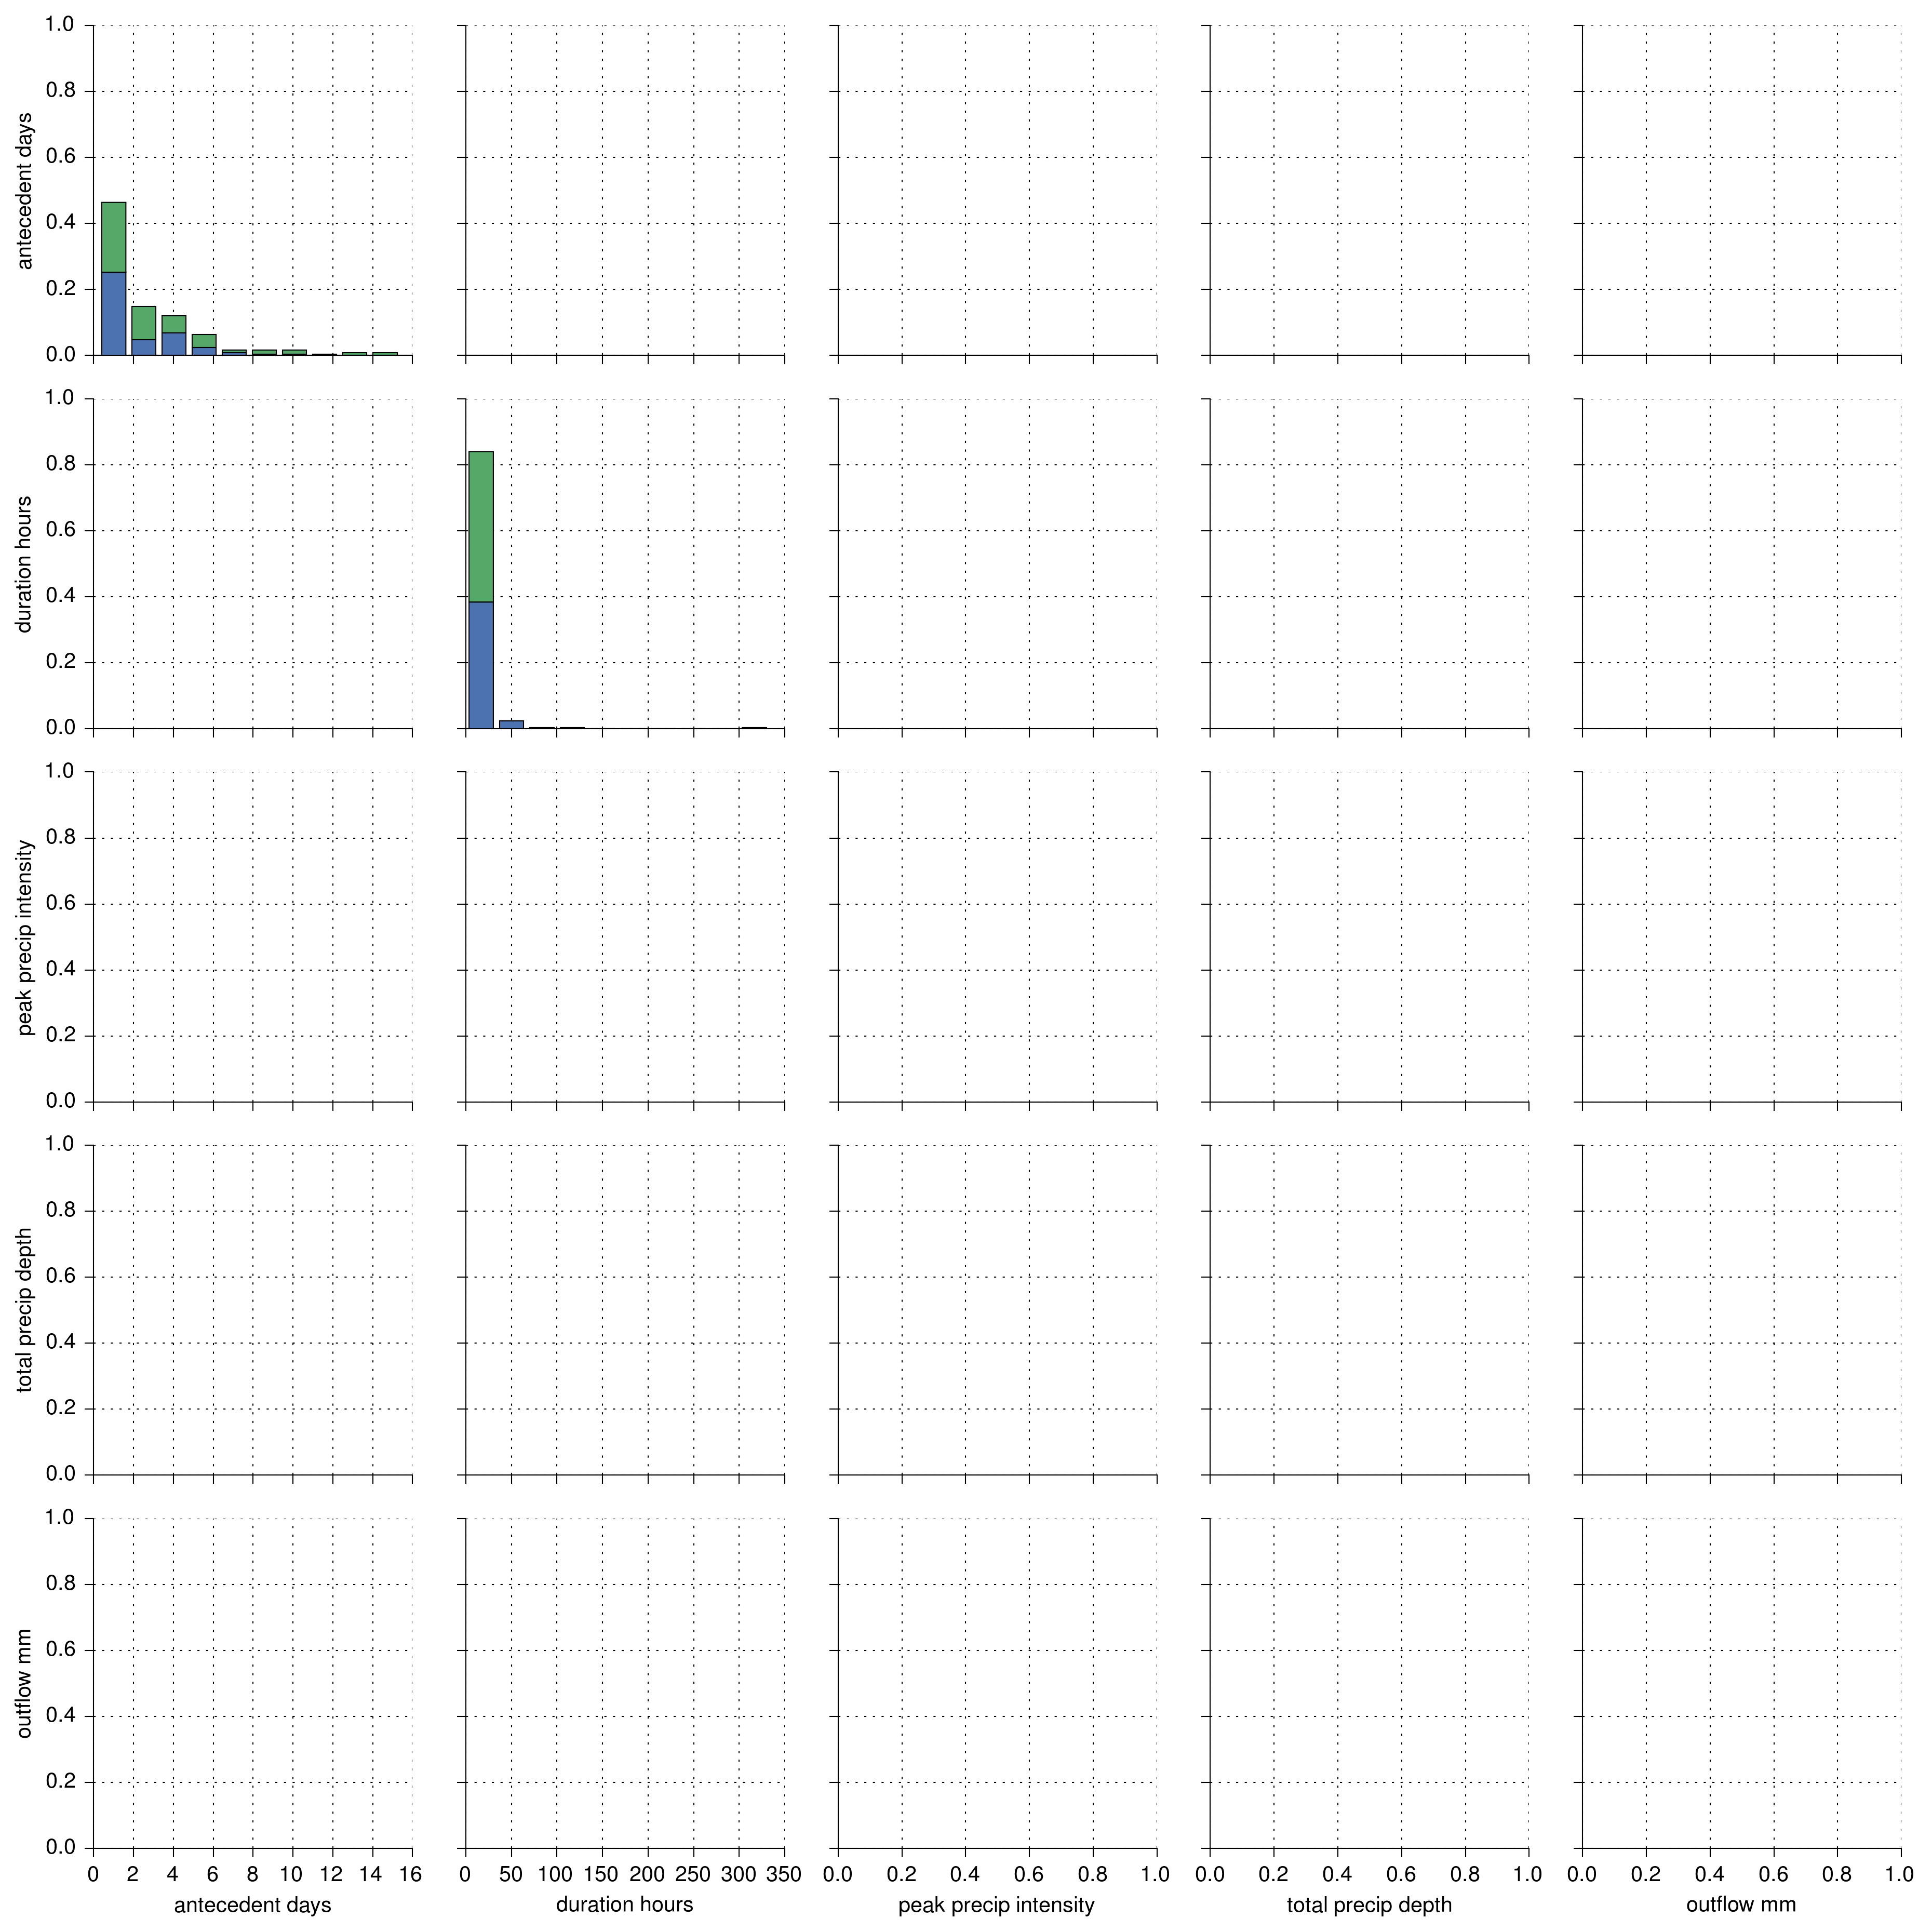

In [15]:
%matplotlib inline
pybmp.setMPLStyle()
for site in [ED1, LV2, LV4]:
    for by in ['year', 'outflow', 'season']:
        try:               
            site.hydro_pairplot(by=by)
        except:
            print('failed on {}, {}'.format(site, by))

### Prevalence Tables

In [16]:
prev_tables = pandas.ExcelWriter('output/xlsx/CVCWQ_DataInventory.xlsx')
for site in [ED1, LV1, LV2, LV4]:
    stype = 'composite'
    site.prevalence_table()[stype].to_excel(prev_tables, sheet_name='{}'.format(site.siteid))

prev_tables.save()
prev_tables.close()

### Concentrations Stats

In [17]:
concfile = pandas.ExcelWriter('output/xlsx/CVCWQ_ConcStats.xlsx')
for site in [ED1, LV1, LV2, LV4]:
    concs = site.wq_summary('concentration', sampletype='composite').T
    concs.to_excel(concfile, sheet_name=site.siteid, na_rep='--')

concfile.save()

### Load Stats

In [18]:
load = site.wq_summary('load_outflow', sampletype='composite').stack(level='parameter').stack(level=['load_units'])
load.head(20)

season                                                 All  autumn  \
      parameter                     load_units                       
Count Aluminum (Al)                 g            10.000000       3   
      Cadmium (Cd)                  g            10.000000       3   
      Copper (Cu)                   g            10.000000       3   
      Dissolved Chloride (Cl)       g            10.000000       3   
      Escherichia coli              CFU           2.000000       2   
      Iron (Fe)                     g            10.000000       3   
      Lead (Pb)                     g            10.000000       3   
      Nickel (Ni)                   g            10.000000       3   
      Nitrate (N)                   g            10.000000       3   
      Nitrate + Nitrite             g            10.000000       3   
      Orthophosphate (P)            g            10.000000       3   
      Total Kjeldahl Nitrogen (TKN) g            10.000000       3   
      Total Oil & Grease            g             4.000000       3   
      Total Phosphorus              g            10.000000       3   
      Total Suspended Solids        g            10.000000       3   
      Zinc (Zn)                     g            10.000000       3   
Mean  Aluminum (Al)                 g             6.369875       0   
      Cadmium (Cd)                  g             0.005554       0   
      Copper (Cu)                   g             0.460889       0   
      Dissolved Chloride (Cl)       g           718.607580       0   

season                                               spring       summer  \
      parameter                     load_units                             
Count Aluminum (Al)                 g              2.000000     4.000000   
      Cadmium (Cd)                  g              2.000000     4.000000   
      Copper (Cu)                   g              2.000000     4.000000   
      Dissolved Chloride (Cl)       g              2.000000     4.000000   
      Escherichia coli              CFU                 NaN          NaN   
      Iron (Fe)                     g              2.000000     4.000000   
      Lead (Pb)                     g              2.000000     4.000000   
      Nickel (Ni)                   g              2.000000     4.000000   
      Nitrate (N)                   g              2.000000     4.000000   
      Nitrate + Nitrite             g              2.000000     4.000000   
      Orthophosphate (P)            g              2.000000     4.000000   
      Total Kjeldahl Nitrogen (TKN) g              2.000000     4.000000   
      Total Oil & Grease            g                   NaN     1.000000   
      Total Phosphorus              g              2.000000     4.000000   
      Total Suspended Solids        g              2.000000     4.000000   
      Zinc (Zn)                     g              2.000000     4.000000   
Mean  Aluminum (Al)                 g              3.709729    13.437367   
      Cadmium (Cd)                  g              0.001113     0.013101   
      Copper (Cu)                   g              0.110894     1.067511   
      Dissolved Chloride (Cl)       g           1188.616800  1039.625550   

season                                              winter  
      parameter                     load_units              
Count Aluminum (Al)                 g             1.000000  
      Cadmium (Cd)                  g             1.000000  
      Copper (Cu)                   g             1.000000  
      Dissolved Chloride (Cl)       g             1.000000  
      Escherichia coli              CFU                NaN  
      Iron (Fe)                     g             1.000000  
      Lead (Pb)                     g             1.000000  
      Nickel (Ni)                   g             1.000000  
      Nitrate (N)                   g             1.000000  
      Nitrate + Nitrite             g             1.000000  
      Orthophosphate (P)            g             1.00

In [19]:
loadfile = pandas.ExcelWriter('output/xlsx/CVCWQ_LoadStats.xlsx')
for site in [ED1, LV1, LV2, LV4]:
    load = (
        site.wq_summary('load_outflow', sampletype='composite')
            .stack(level='parameter')
            .stack(level='load_units')
    )
    load.to_excel(loadfile, sheet_name=site.siteid, na_rep='--')

loadfile.save()

### ~~All Loads~~ Tidy Data

In [20]:
loadfile = pandas.ExcelWriter('output/xlsx/CVCWQ_TidyData.xlsx')
for site in [ED1, LV1, LV2, LV4]:
    #loads = cvc.summary.siteLoads(site, sampletype='composite')
    #loads.to_excel(loadfile, sheet_name=site.siteid, na_rep='--', float_format='%.2f')
    site.tidy_data.to_excel(loadfile, sheet_name=site.siteid, na_rep='--')
    
loadfile.save()

### Total Loads Summary

In [21]:
loadfile = pandas.ExcelWriter('output/xlsx/CVCWQ_LoadTotals.xlsx')
for site in [ED1, LV1, LV2, LV4]:
    loads = site.load_totals(sampletype='composite')
    loads.to_excel(loadfile, sheet_name=site.siteid, na_rep='--')
    
loadfile.save()

## Analysis

### ISRs, Precip-outflow scatter plots

In [22]:
seaborn.set(style='ticks', context='paper')
pybmp.setMPLStyle()
for site in [ED1, LV1, LV2, LV4]:
    print('\n----Summarizing {0}----'.format(site.siteid))
    site.allISRs('composite', version='draft')
    
    site.hydro_jointplot(
        xcol='total_precip_depth', 
        ycol='outflow_mm', 
        conditions="outflow_mm > 0", 
        one2one=True
    )

    site.hydro_jointplot(
        xcol='antecedent_days', 
        ycol='outflow_mm', 
        conditions="outflow_mm > 0", 
        one2one=False
    )

    site.hydro_jointplot(
        xcol='total_precip_depth', 
        ycol='antecedent_days', 
        conditions="outflow_mm == 0", 
        one2one=False
    )
    
    site.hydro_jointplot(
        xcol='peak_precip_intensity', 
        ycol='peak_outflow', 
        conditions=None, 
        one2one=False
    )
    
    plt.close('all')


----Summarizing ED-1----

----Summarizing LV-1----

----Summarizing LV-2----

----Summarizing LV-4----


## WQ Comparison

### Lists of sites to compare

In [23]:
site_lists = [
    [ED1, LV1],
    [LV1, LV2, LV4],
]

### Individual Figures

In [24]:
for sl in site_lists:
    print('\n----Comparing {}----'.format(', '.join([s.siteid for s in sl])))
    for poc in POCs:
        wqcomp = pycvc.summary.WQComparison(sl, 'composite', poc, nsqdata, bmpdb)
        print('  ' + poc)
        wqcomp.seasonalBoxplots(load=False, finalOutput=True)
        wqcomp.seasonalBoxplots(load=True, finalOutput=True)
        wqcomp.landuseBoxplots(finalOutput=True)
        wqcomp.bmpCategoryBoxplots(finalOutput=True)
        wqcomp.parameterStatPlot(finalOutput=True)
        wqcomp.parameterTimeSeries(finalOutput=True)  
        wqcomp.parameterStatPlot(load=True, finalOutput=True)
        wqcomp.parameterTimeSeries(load=True, finalOutput=True)  

        plt.close('all')


----Comparing ED-1, LV-1----
  Cadmium (Cd)
  Copper (Cu)
  Iron (Fe)
  Lead (Pb)
  Nickel (Ni)
  Zinc (Zn)
  Nitrate (N)
  Nitrate + Nitrite
  Total Phosphorus
  Total Suspended Solids

----Comparing LV-1, LV-2, LV-4----
  Cadmium (Cd)
  Copper (Cu)
  Iron (Fe)
  Lead (Pb)
  Nickel (Ni)
  Zinc (Zn)
  Nitrate (N)
  Nitrate + Nitrite
  Total Phosphorus
  Total Suspended Solids


### Megafigures

In [25]:
for sl in site_lists:
    print('\n----Megafigs with {}----'.format(', '.join([s.siteid for s in sl])))
    
    # construct the megafigures
    mf1 = pycvc.summary.WQMegaFigure(sl, 'composite', POCs[:6], 1, nsqdata, bmpdb)
    mf2 = pycvc.summary.WQMegaFigure(sl, 'composite', POCs[6:], 2, nsqdata, bmpdb)
    for n, mf in enumerate([mf1, mf2]):
        print('\tTime Series {0}'.format(n+1))
        mf.timeseriesFigure(load=False)

        mf.timeseriesFigure(load=True)

        print('\tStat plots {0}'.format(n+1))
        mf.statplotFigure(load=False)
        mf.statplotFigure(load=True)

        print('\tBMPDB Boxplots {0}'.format(n+1))
        mf.bmpCategoryBoxplotFigure()

        print('\tNSQD Boxplots {0}'.format(n+1))
        mf.landuseBoxplotFigure()

        print('\tSeasonal Boxplots {0}'.format(n+1))
        mf.seasonalBoxplotFigure(load=False)
        mf.seasonalBoxplotFigure(load=True)
     
    plt.close('all')


----Megafigs with ED-1, LV-1----
	Time Series 1
	Stat plots 1
	BMPDB Boxplots 1
	NSQD Boxplots 1
	Seasonal Boxplots 1
	Time Series 2
	Stat plots 2
	BMPDB Boxplots 2
	NSQD Boxplots 2
	Seasonal Boxplots 2

----Megafigs with LV-1, LV-2, LV-4----
	Time Series 1
	Stat plots 1
	BMPDB Boxplots 1
	NSQD Boxplots 1
	Seasonal Boxplots 1
	Time Series 2
	Stat plots 2
	BMPDB Boxplots 2
	NSQD Boxplots 2
	Seasonal Boxplots 2
